## Let us perform Web Scraping using BeautifulSoup 

Importing the required libraries and extracting the Movie reviews and their ratings

In [233]:
from bs4 import BeautifulSoup

In [234]:
soup = BeautifulSoup(open("1.html",encoding="utf8"), "html.parser")

Let us take a look at the html structure 

In [235]:
movie_containers = soup.find_all('div' , class_ = 'review-container')
print(type(movie_containers))
print(len(movie_containers))

<class 'bs4.element.ResultSet'>
1124


We can see there are 1124 containers consisting of the reviews and the ratings

Let us try to extract the reviews

In [236]:
first_movie = movie_containers[0]
first_movie.a.text

" Finally, a Show that stays true to it's written roots\n"

Let us try to find the ratings of the reviews

In [237]:
temp = first_movie.span.text

In [238]:
temp

'\n\n\n\n\n\n9/10\n'

We can see that the reviews and ratings require cleaning which we will deal with it later

Let us try to extract all the reviews and the ratings

In [239]:
# Lists to store the scraped data in
reviews = []
ratings = []

# Extract data from individual movie container
for container in movie_containers:
    
    #review
    review = container.a.text
    reviews.append(review)
    
    #rating
    rating = container.span.text
    ratings.append(rating)
   

Let us try to put all the ratings into a dataframe

In [240]:
import pandas as pd
import numpy as np

test_df = pd.DataFrame({'Review': reviews,'Rating': ratings})
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 2 columns):
Review    1124 non-null object
Rating    1124 non-null object
dtypes: object(2)
memory usage: 17.6+ KB
None


,Review,Rating
0,"Finally, a Show that stays true to it's writt...",\n\n\n\n\n\n9/10\n
1,Excellent adaptation.\n,\n\n\n\n\n\n10/10\n
2,One of the most stunning shows on television\n,\n\n\n\n\n\n10/10\n
3,Lord of the Rings - I think not!\n,\n\n\n\n\n\n10/10\n
4,Fantasy has never seemed so real\n,\n\n\n\n\n\n10/10\n


And woah we have scrapped all the reviews and the ratings 
Pandas do actualy make our work easier!

Let us perform cleaning on the reviews and the ratings

In [241]:
test_df.loc[:, 'Rating'] = test_df['Rating'].str[6:8]

In [242]:
test_df.loc[:, 'Rating'] = test_df['Rating'].str.replace('/', '')
test_df.loc[:, 'Review'] = test_df['Review'].str.replace('\n', '')
test_df.loc[:, 'Rating'] = test_df['Rating'].str.replace('-', '')

In [243]:
import re
def split_it(rating):
    return re.sub('[a-zA-Z]+','NaN', rating)

In [244]:
test_df['Rating'] = test_df['Rating'].apply(split_it)

In [245]:
test_df = test_df[test_df.Rating.str.contains("NaN") == False]

In [246]:
test_df['Rating'] = test_df['Rating'].apply(pd.to_numeric)

In [247]:
test_df.head()

,Review,Rating
0,"Finally, a Show that stays true to it's writt...",9.0
1,Excellent adaptation.,10.0
2,One of the most stunning shows on television,10.0
3,Lord of the Rings - I think not!,10.0
4,Fantasy has never seemed so real,10.0


We can see that we have cleaned the Ratings and the Reviews
There might be some redundency in the cleaning which I will update later

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

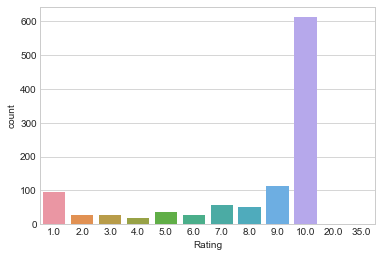

In [249]:
sns.countplot(test_df['Rating'])

We can see that there are some Ratings above 10 that we need to get rid of.

In [250]:
test_df = test_df[test_df.Rating <= 10]

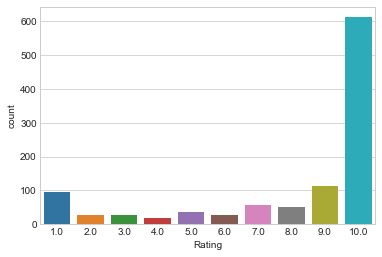

In [251]:
sns.countplot(test_df['Rating'])

Let us look at the descriptions

In [252]:
test_df.describe()

,Rating
count,1065.000000
mean,8.071362
std,3.015090
min,1.000000
25%,7.000000
50%,10.000000
75%,10.000000
max,10.000000


Let us look if there is a relation between a review length and a Rating

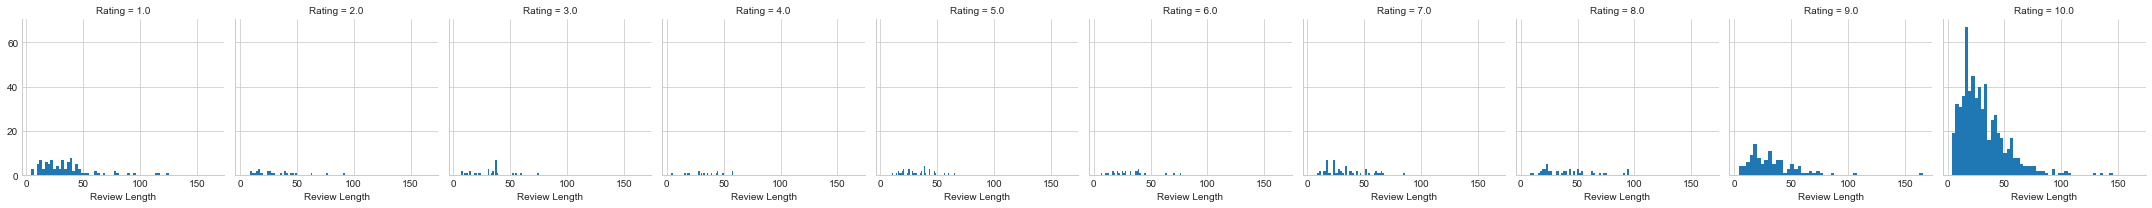

In [253]:
test_df['Review']=test_df['Review'].astype(str)
test_df['Review Length']=test_df['Review'].apply(len)

g = sns.FacetGrid(data=test_df, col='Rating')
g.map(plt.hist, 'Review Length', bins=50)

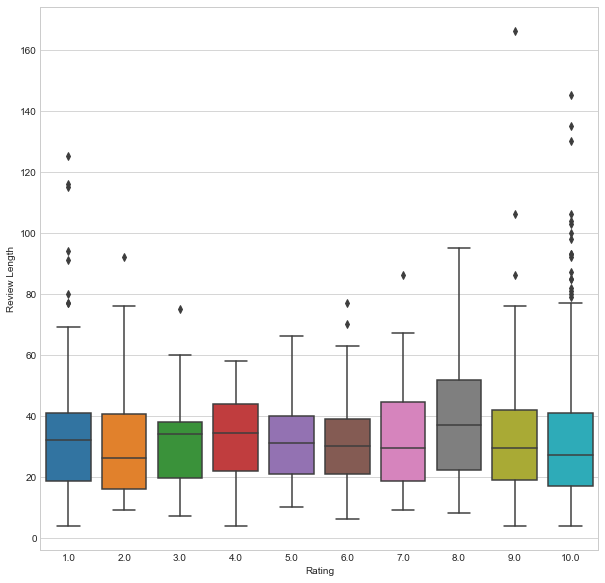

In [254]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Rating', y='Review Length', data=test_df)

We can see that Reviews with ratings 1 and and 8 are the longest

Let us try to use machine learning and use NLP analytics

In [255]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

In [256]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Let us try to extract all the words and try to perform analysis on it

In [257]:
a = test_df['Review'].str.lower().str.cat(sep=' ')

In [258]:
# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

In [259]:
#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

newStopWords = ['game','thrones', 'bran', 'stark', 'dragons']
stop_words.extend(newStopWords)

In [260]:
word_tokens = word_tokenize(b)

We have extracted all the words in the reviews. Let us find the total length

In [261]:
len(word_tokens)

6030

We will now remove the stop words from the reviews

In [262]:
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [263]:
len(filtered_sentence)

3599

We have removed all the stop words and reduced the size by half.

In [264]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]   

Let us look at the top 10 most used words in a review.

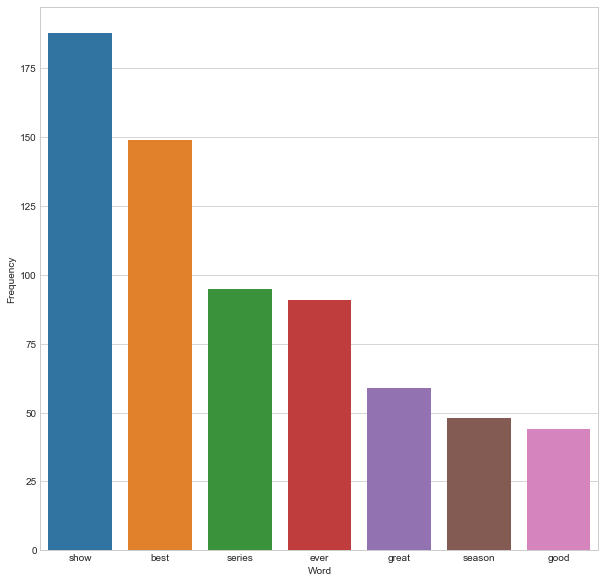

In [265]:
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

We can see that the most common words are positive indicating how great Game of thrones is!

In [266]:
from wordcloud import WordCloud, STOPWORDS

In [267]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

Let us visualise the most common words

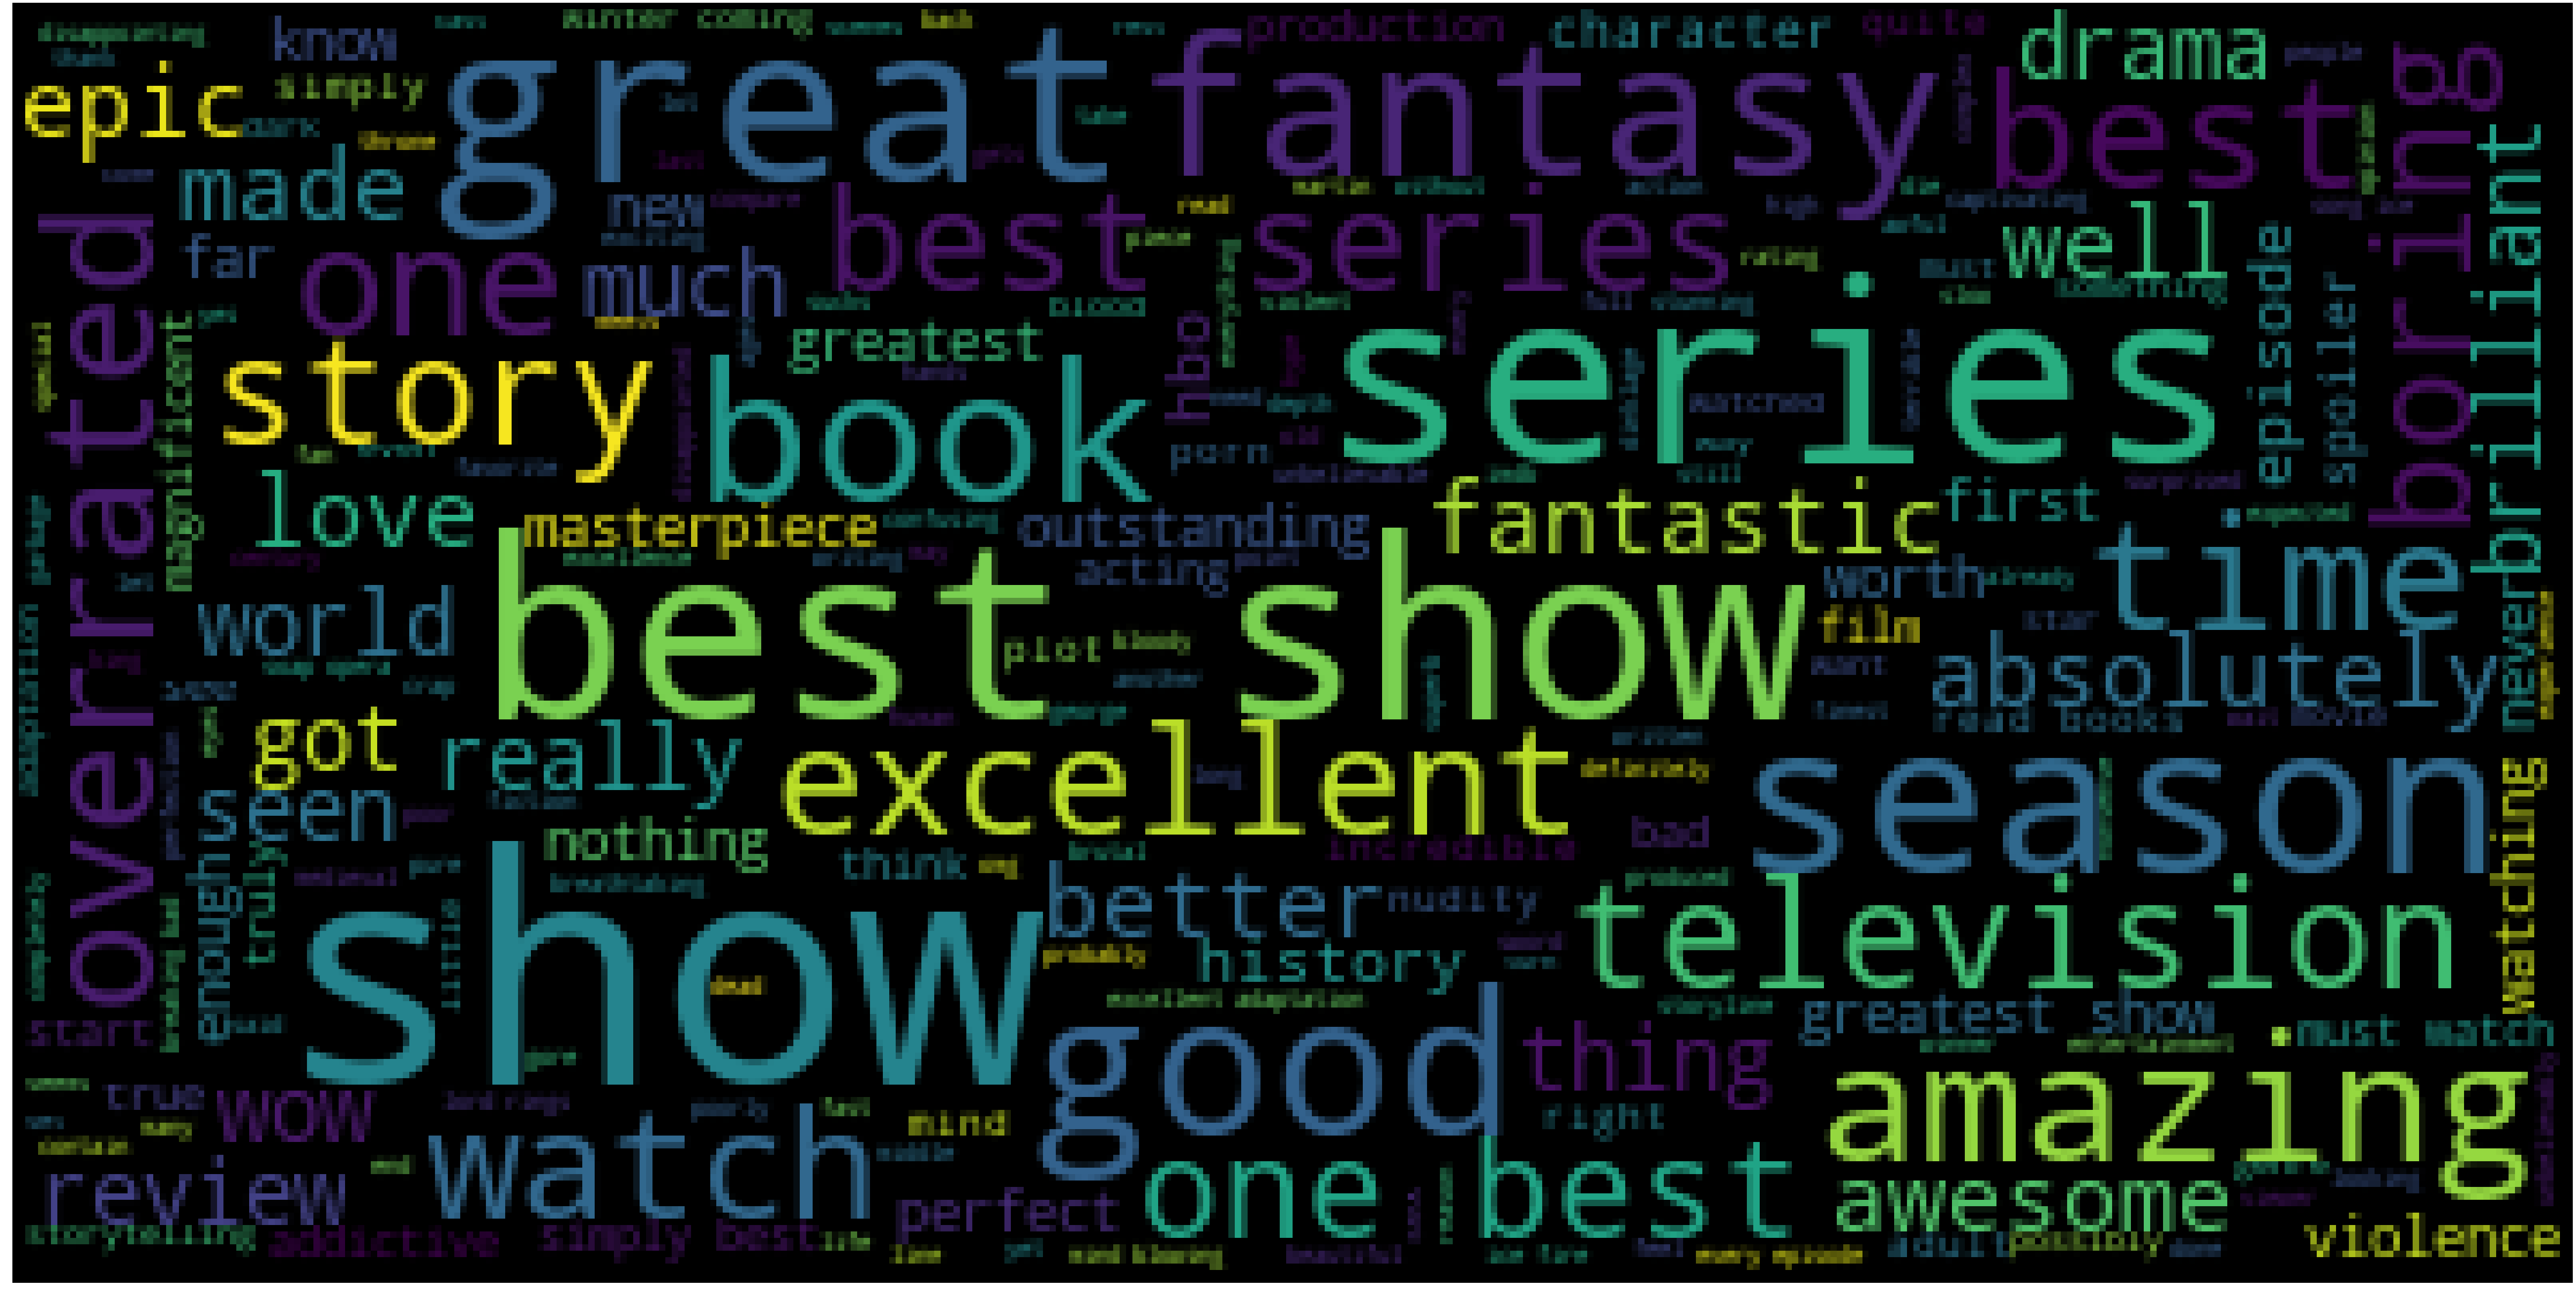

In [268]:
wc(cleaned_data_title,'black','Most Used Words')

Let us try to perform analysis on the entire review rather than all the words.
For this we make use of the TextBlob

In [269]:
from textblob import TextBlob

bloblist_desc = list()

df_review_str=test_df['Review'].astype(str)

In [270]:
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

We will try to perform sentimental analysis and try to classify whether a review is a positive or negative

In [271]:
df_polarity_desc.head()

,Review,sentiment,polarity
0,"Finally, a Show that stays true to it's writt...",0.175,0.825
1,Excellent adaptation.,1.000,1.000
2,One of the most stunning shows on television,0.500,0.750
3,Lord of the Rings - I think not!,0.000,0.000
4,Fantasy has never seemed so real,0.200,0.300


In [272]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] >= 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] >= -0.09:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

After looking at the sentiments I have used the above values. This is a personal perference which you can change according to your choice.

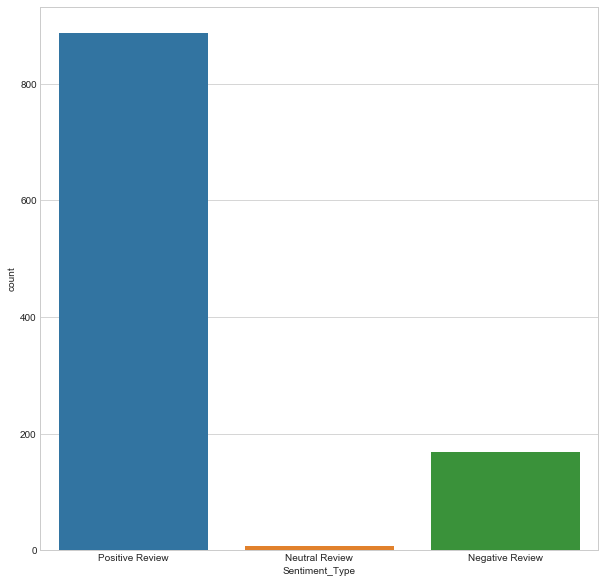

In [273]:
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

In [274]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']

In [275]:
negative_reviews.head()

,Review,sentiment,polarity,Sentiment_Type
15,Heads up for GAME OF THRONES,-0.400000,0.400000,Negative Review
22,"As expected, some will love it, some will hat...",-0.133333,0.633333,Negative Review
36,Possibly the worst storyline I will ever enco...,-0.500000,1.000000,Negative Review
42,On finding Game of Thrones on VHS,-0.400000,0.400000,Negative Review
43,Unbelievably awful,-1.000000,1.000000,Negative Review


Let us look at the most used words in all the positive reviews

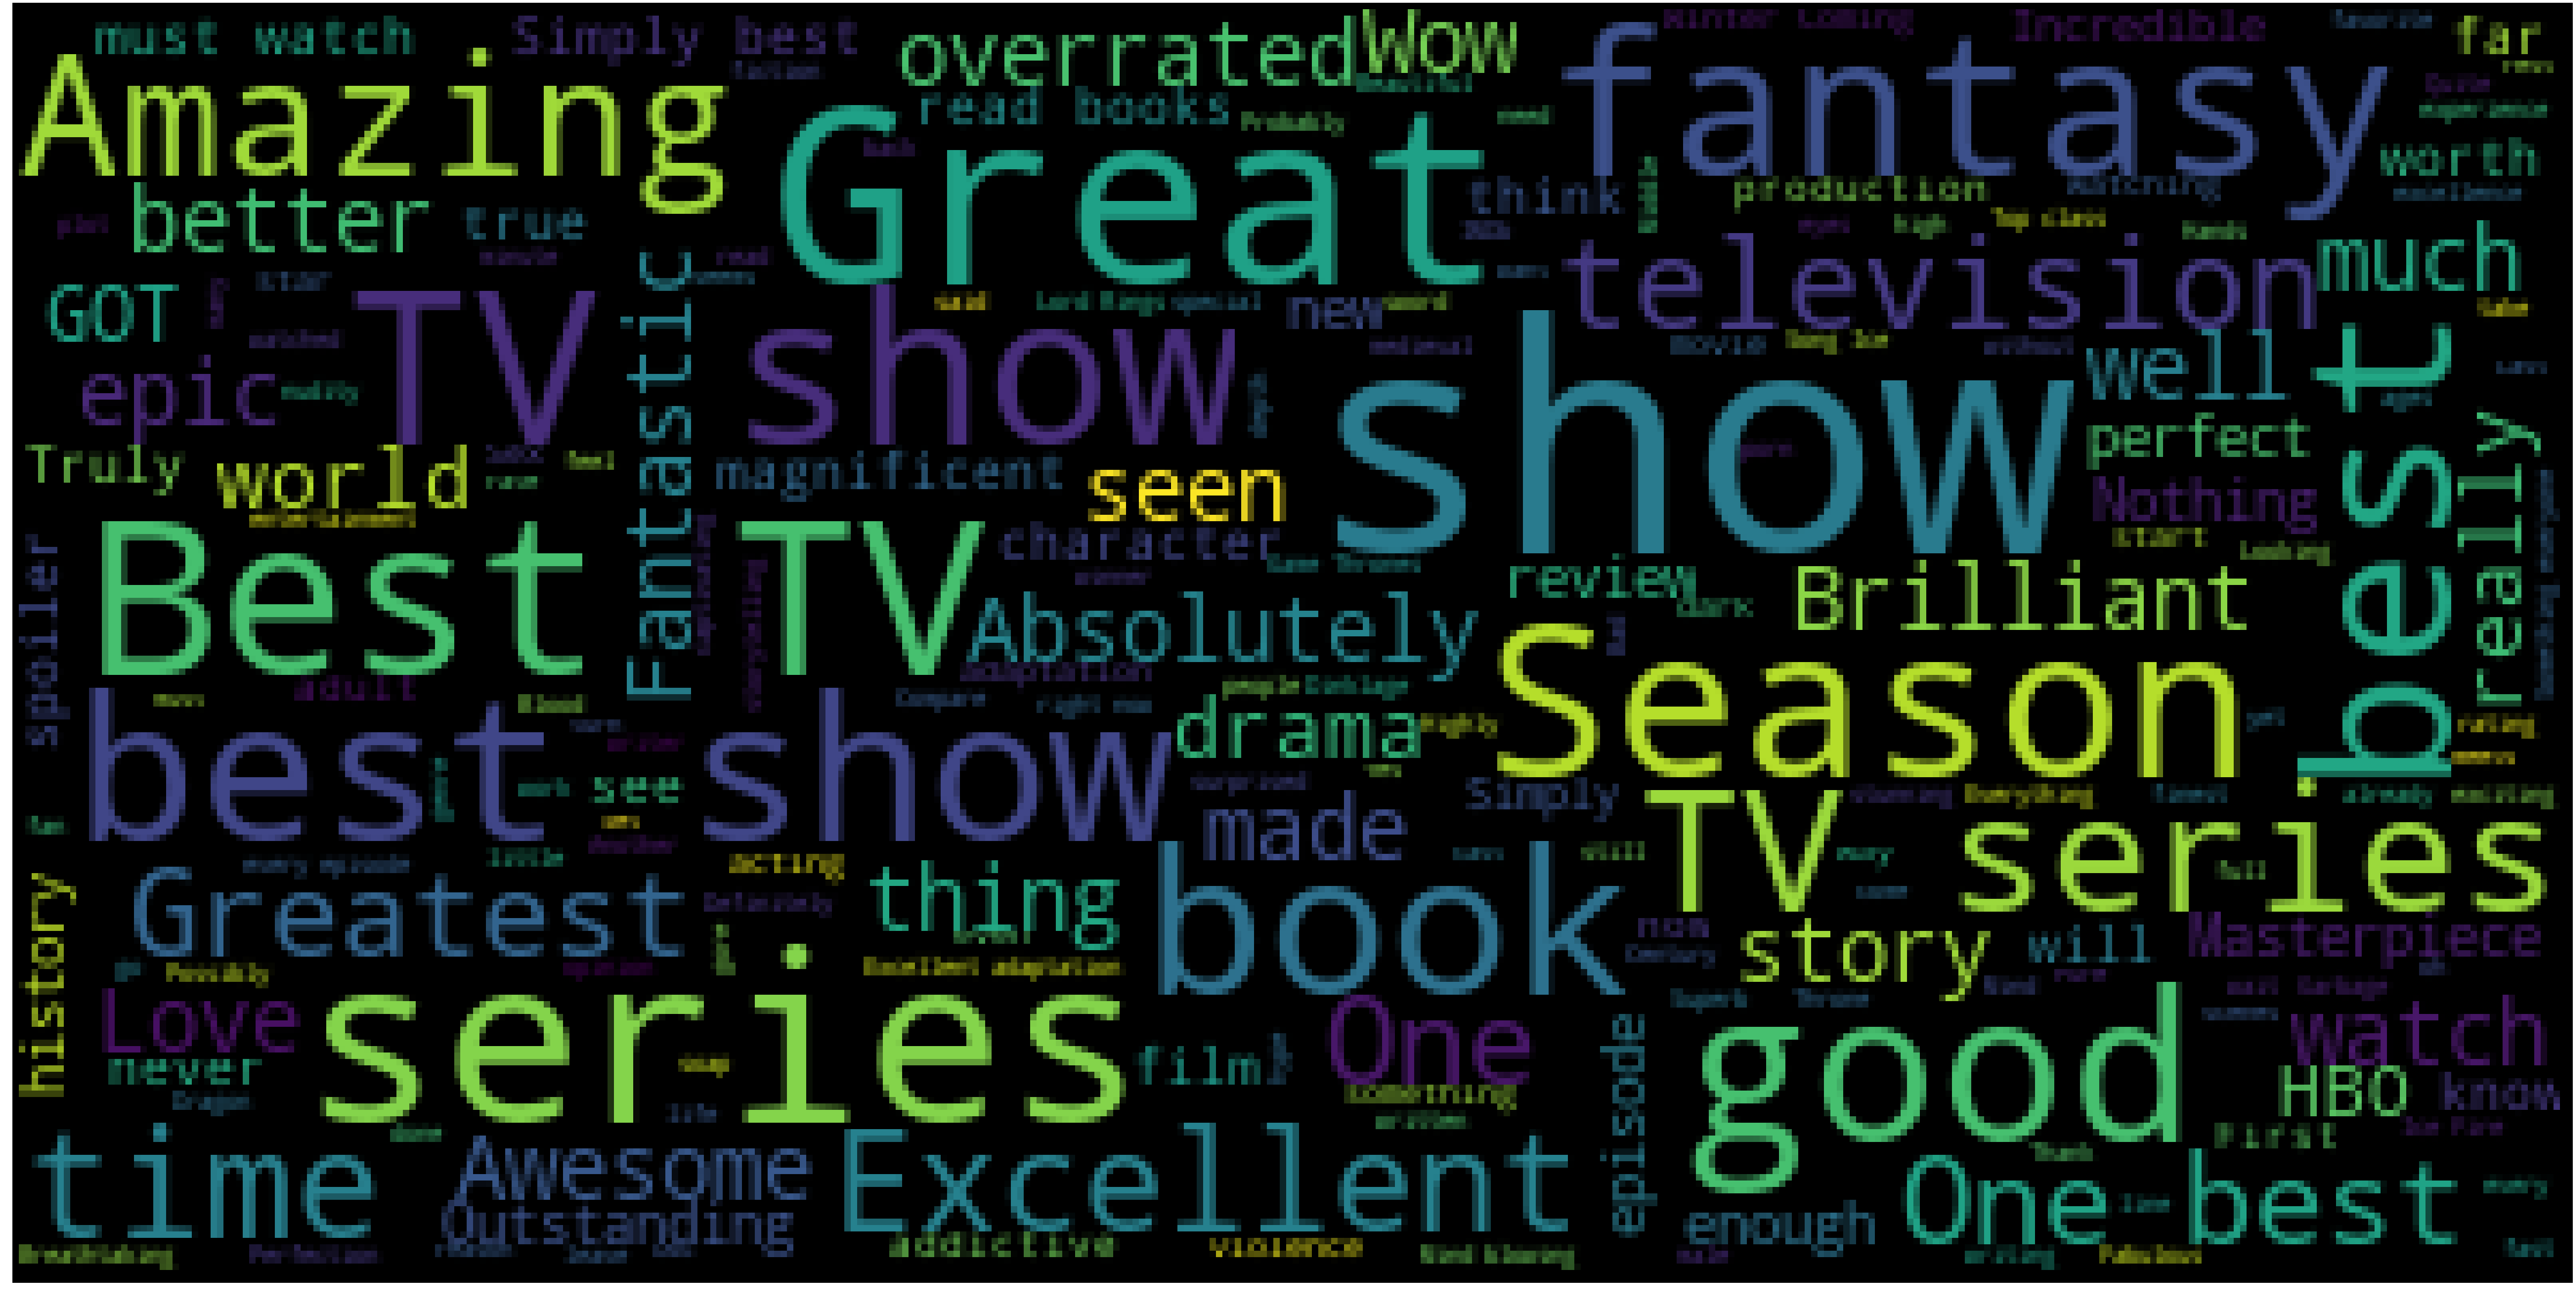

In [276]:
wc(positive_reviews['Review'],'black','Most Used Words')

Let us look at the most used words in all the negative reviews

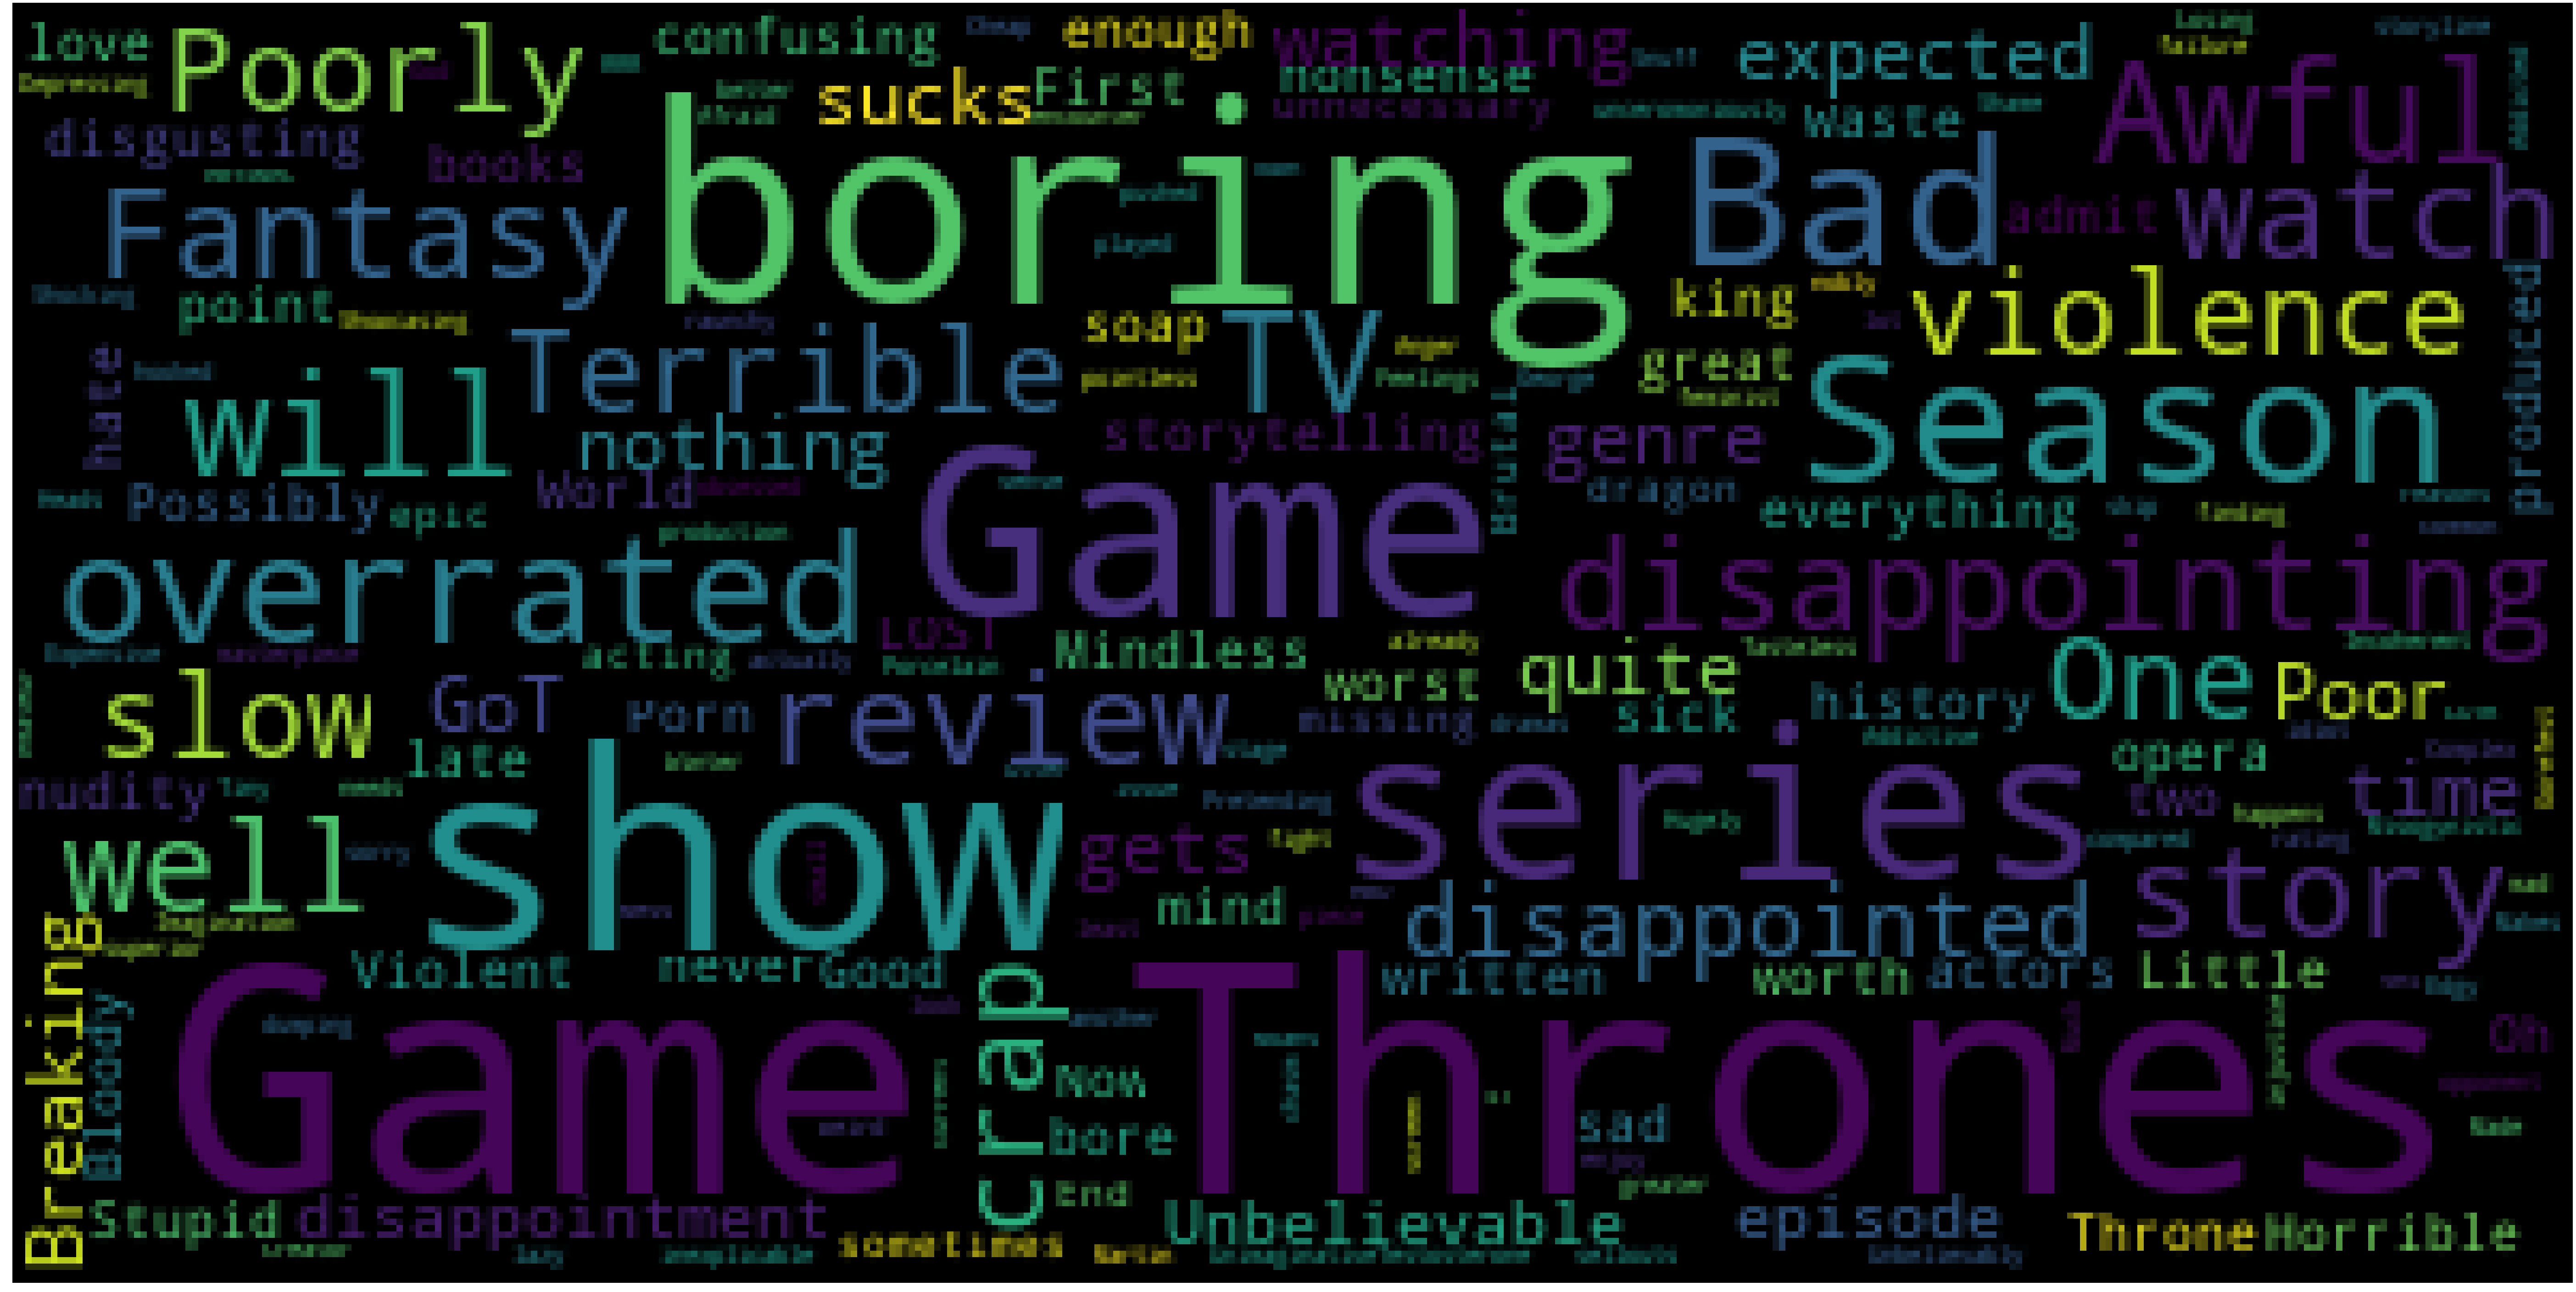

In [277]:
wc(negative_reviews['Review'],'black','Most Used Words')

In [278]:
import string
def text_process(review):
    nopunc=[word for word in review if word not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Let us now train a model 
We are taking only review with ratings 1 and 10 to perform the analysis to make the analysis more simple.

In [279]:
test_df=test_df.dropna(axis=0,how='any')
rating_class = test_df[(test_df['Rating'] == 1) | (test_df['Rating'] == 10)]
X_review=rating_class['Review']
y=rating_class['Rating']

In [280]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_review)

In [281]:
X_review = bow_transformer.transform(X_review)

In [282]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)

Let us train a model using Multinomial Naive Bayes as it works great on text.

In [283]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
predict=nb.predict(X_test)

In [284]:
predict

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.,  1., 10., 10., 10.,  1., 10.,
       10., 10., 10., 10.,  1., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10.,  1., 10., 10., 10.,  1., 10., 10., 10., 10., 10.,
       10.,  1., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        1., 10.,  1., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10.,  1.,  1., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10.,  1., 10., 10., 10., 10., 10., 10.,
       10.,  1., 10., 10., 10.,  1., 10.,  1., 10., 10., 10., 10.,  1.,
       10., 10., 10., 10.,  1., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.,  1., 10.,  1.,  1.,  1., 10.,
       10., 10., 10., 10.,  1., 10., 10., 10., 10., 10., 10., 10

Let us find the accuracy, precision and recall

In [285]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, predict))
print('\n Accuracy:')
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

[[ 14  26]
 [ 14 159]]

 Accuracy:
0.812206572769953
              precision    recall  f1-score   support

         1.0       0.50      0.35      0.41        40
        10.0       0.86      0.92      0.89       173

   micro avg       0.81      0.81      0.81       213
   macro avg       0.68      0.63      0.65       213
weighted avg       0.79      0.81      0.80       213



We have a 81 percent accuracy but a very recall score indicating that movies with ratings 1's
are not classified properly this maybe due to a large ratio of positive review. 
Hence it has a bad recall.


Let us test our model

In [286]:
rating_positive=test_df['Review'][6]
rating_positive

' This TV series is magnificent!'

In [287]:
rating_postive_transformed = bow_transformer.transform([rating_positive])
nb.predict(rating_postive_transformed)[0]

10.0

In [288]:
rating_negative=test_df['Review'][54]
rating_negative

' disgusting, overrated, pointless'

In [289]:
rating_negative_transformed = bow_transformer.transform([rating_negative])
nb.predict(rating_negative_transformed)[0]

1.0

Let us try SMOTE

In [296]:
from imblearn.over_sampling import SMOTE

In [297]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (494, 1058)
Number transactions y_train dataset:  (494,)
Number transactions X_test dataset:  (213, 1058)
Number transactions y_test dataset:  (213,)


In [298]:
print("Before OverSampling, counts of label '10': {}".format(sum(y_train==10)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y_train==1)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '10': {}".format(sum(y_train_res==10)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))

Before OverSampling, counts of label '10': 439
Before OverSampling, counts of label '1': 55 

After OverSampling, the shape of train_X: (878, 1058)
After OverSampling, the shape of train_y: (878,) 

After OverSampling, counts of label '10': 439
After OverSampling, counts of label '1': 439


In [299]:
nb.fit(X_train_res, y_train_res)
predict_smote=nb.predict(X_test)

In [300]:
print(confusion_matrix(y_test, predict_smote))
print('\n Accuracy:')
print(accuracy_score(y_test, predict_smote))
print(classification_report(y_test, predict_smote))

[[ 27  13]
 [ 50 123]]

 Accuracy:
0.704225352112676
              precision    recall  f1-score   support

         1.0       0.35      0.68      0.46        40
        10.0       0.90      0.71      0.80       173

   micro avg       0.70      0.70      0.70       213
   macro avg       0.63      0.69      0.63       213
weighted avg       0.80      0.70      0.73       213



Although, our overall accuracy has decreased. We have increased the recall to 68 percent.
Hence our model can classify review with 1 rating better. <br>
Comparing with the original model without undersampling

In [301]:
print(confusion_matrix(y_test, predict))
print('\n Accuracy:')
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

[[ 14  26]
 [ 14 159]]

 Accuracy:
0.812206572769953
              precision    recall  f1-score   support

         1.0       0.50      0.35      0.41        40
        10.0       0.86      0.92      0.89       173

   micro avg       0.81      0.81      0.81       213
   macro avg       0.68      0.63      0.65       213
weighted avg       0.79      0.81      0.80       213

